In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import numpy as np


In [14]:
filtered_df = pd.read_csv("/loans_lending_vol.csv")

In [15]:
filtered_df.head()

,msa_name,date,total_loans,total_lending_volume
0,"Aberdeen, SD",2011-07-01,100765239,5.619444e+11
1,"Aberdeen, SD",2011-10-01,102317952,5.677784e+11
2,"Aberdeen, SD",2012-01-01,103030966,5.692122e+11
3,"Aberdeen, SD",2012-04-01,101918904,5.800548e+11
4,"Aberdeen, SD",2012-07-01,103979719,5.908302e+11


In [16]:
# Ensure 'date' column is in datetime format
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Sort by MSA and date (important before pct_change)
filtered_df = filtered_df.sort_values(by=['msa_name', 'date'])

# Group by msa_name and compute LEAP and MEAP
filtered_df['LEAP'] = filtered_df.groupby('msa_name')['total_loans'].pct_change()
filtered_df['MEAP'] = filtered_df.groupby('msa_name')['total_lending_volume'].pct_change()

In [17]:
filtered_df

,msa_name,date,total_loans,total_lending_volume,LEAP,MEAP
0,"Aberdeen, SD",2011-07-01,100765239,5.619444e+11,NaN,NaN
1,"Aberdeen, SD",2011-10-01,102317952,5.677784e+11,0.015409,0.010382
2,"Aberdeen, SD",2012-01-01,103030966,5.692122e+11,0.006969,0.002525
3,"Aberdeen, SD",2012-04-01,101918904,5.800548e+11,-0.010793,0.019048
4,"Aberdeen, SD",2012-07-01,103979719,5.908302e+11,0.020220,0.018577
...,...,...,...,...,...,...
33820,"Zanesville, OH",2024-01-01,105525847,1.699981e+12,0.014055,-0.000927
33821,"Zanesville, OH",2024-04-01,105739459,1.717862e+12,0.002024,0.010518
33822,"Zanesville, OH",2024-07-01,108970288,1.731846e+12,0.030555,0.008141
33823,"Zanesville, OH",2024-10-01,111325185,1.748291e+12,0.021610,0.009496


In [18]:
filtered_df['date'] = pd.to_datetime(filtered_df['date'])  # Ensure date is datetime
filtered_df = filtered_df[filtered_df['date'].dt.year < 2020]

filtered_df.loc[:, 'LEAP'] = filtered_df['LEAP'].clip(-0.2, 0.2)
filtered_df.loc[:, 'MEAP'] = filtered_df['MEAP'].clip(-0.2, 0.2)

In [19]:
# Create a dictionary to store results
leaf_results = []

# Loop over each unique MSA
for msa in filtered_df['msa_name'].unique():
    msa_data = filtered_df[filtered_df['msa_name'] == msa].dropna(subset=['LEAP', 'MEAP'])

    if len(msa_data) >= 3:  # Require at least 3 data points to run regression
        X = msa_data['MEAP'].values.reshape(-1, 1)
        y = msa_data['LEAP'].values

        model = LinearRegression()
        model.fit(X, y)

        beta = model.coef_[0]
        r_squared = model.score(X, y)

        leaf_results.append({
            'msa_name': msa,
            'LEAF': beta,
            'R_squared': r_squared
        })

# Convert results to DataFrame
leaf_df = pd.DataFrame(leaf_results)

# Display the LEAF table
leaf_df.head()

,msa_name,LEAF,R_squared
0,"Aberdeen, SD",0.514060,0.078143
1,"Aberdeen, WA",1.084347,0.135951
2,"Abilene, TX",-0.772005,0.276198
3,"Adrian, MI",-0.129053,0.005901
4,"Akron, OH",0.230956,0.020311


In [20]:
# Filter out weak relationships
strong_leaf_df = leaf_df[leaf_df['R_squared'] >= 0.1]

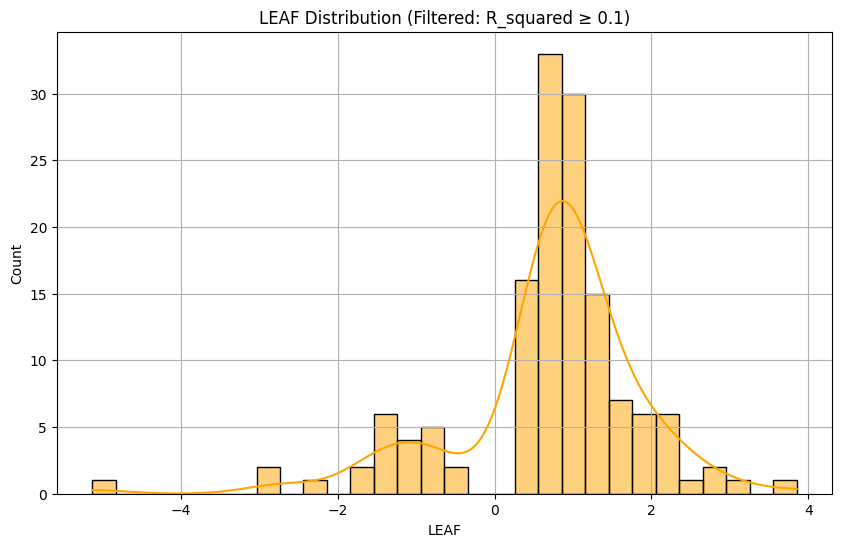

count    141.000000
mean       0.690837
std        1.187182
min       -5.131847
25%        0.533689
50%        0.851061
75%        1.222003
max        3.852601
Name: LEAF, dtype: float64


In [21]:
# Plot updated distribution
plt.figure(figsize=(10, 6))
sns.histplot(strong_leaf_df['LEAF'], kde=True, bins=30, color='orange')
plt.title('LEAF Distribution (Filtered: R_squared ≥ 0.1)')
plt.xlabel('LEAF')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Summary stats of strong LEAFs
print(strong_leaf_df['LEAF'].describe())

In [25]:
asset_sizes = pd.read_excel('/msa_asset_size.xlsx')

In [26]:
strong_leaf_df = pd.merge(strong_leaf_df, asset_sizes, on='msa_name', how='inner')

In [27]:
strong_leaf_df

,msa_name,LEAF,R_squared,assetSize
0,"Aberdeen, WA",1.084347,0.135951,3802.0
1,"Abilene, TX",-0.772005,0.276198,601719.0
2,"Albany, OR",1.033140,0.246862,163152.0
3,"Anchorage, AK",0.740045,0.218930,12066329.0
4,"Andrews, TX",-1.540673,0.137967,6729.0
...,...,...,...,...
136,"Vallejo, CA",1.176307,0.217437,39920.0
137,"Visalia, CA",0.878100,0.107705,135245.0
138,"Warner Robins, GA",0.670155,0.130922,36545.0
139,"Washington-Arlington-Alexandria, DC-VA-MD-WV",0.463942,0.128351,431167.0


In [28]:
# Show top 10 MSAs with highest LEAF
print(strong_leaf_df.sort_values(by='LEAF', ascending=False).head(10))

# Show bottom 10 (most negative) LEAF values
print(strong_leaf_df.sort_values(by='LEAF').head(10))

              msa_name      LEAF  R_squared  assetSize
16      Brookhaven, MS  3.852601   0.310543    94002.0
18          Burley, ID  3.008171   0.115213      564.0
44     Fort Morgan, CO  2.880744   0.248750     4505.0
7       Baker City, OR  2.744653   0.284655     2928.0
127    Springfield, OH  2.424149   0.190469     4605.0
88   Mountain Home, ID  2.341730   0.155351   764986.0
114          Rolla, MO  2.288378   0.164153    90704.0
83        Missoula, MT  2.266219   0.230824     1612.0
109        Redding, CA  2.171592   0.226900   324512.0
129     Susanville, CA  2.141565   0.118776   106932.0
                         msa_name      LEAF  R_squared  assetSize
92                 Orangeburg, SC -5.131847   0.364989    23342.0
119                Scottsboro, AL -2.828156   0.150364     2289.0
36                     Deming, NM -2.747418   0.146468     5924.0
45                 Fort Payne, AL -2.316017   0.104791     2728.0
12               Bluefield, WV-VA -1.679914   0.199712    14548.0

In [31]:
correlation = strong_leaf_df['LEAF'].corr(strong_leaf_df['assetSize'])
print(f"Correlation between LEAF and asset size: {correlation:.4f}")

Correlation between LEAF and asset size: -0.0270


Pearson correlation: -0.027
P-value: 0.75131


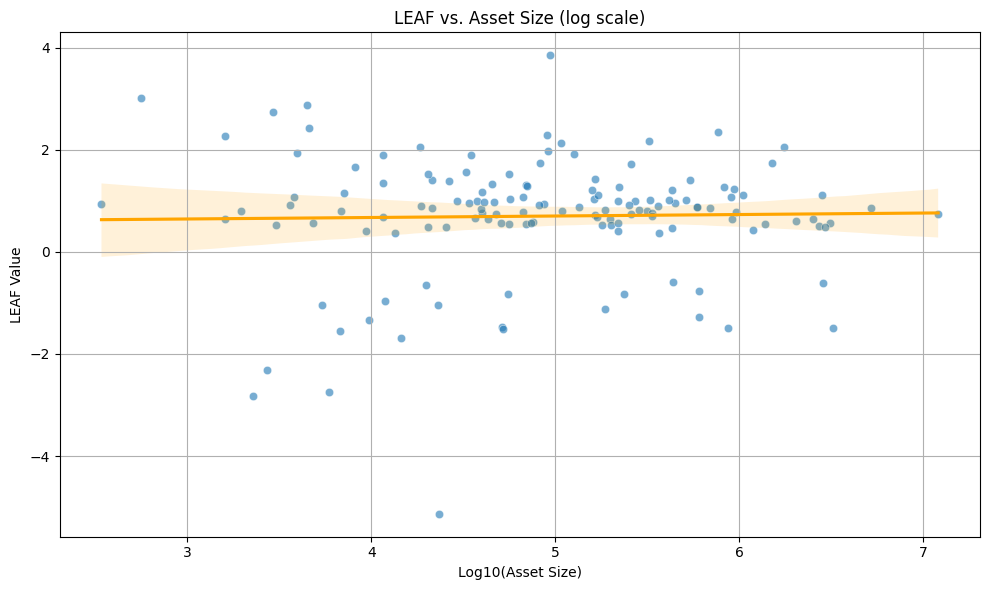

In [32]:
# Drop missing or zero asset sizes
df = strong_leaf_df.dropna(subset=['assetSize', 'LEAF'])
df = df[df['assetSize'] > 0]

# Compute Pearson correlation
corr, pval = pearsonr(df['LEAF'], df['assetSize'])
print(f"Pearson correlation: {corr:.3f}")
print(f"P-value: {pval:.5f}")

# log-transform assetSize for better visualization
strong_leaf_df['log_assetSize'] = np.log10(df['assetSize'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='log_assetSize', y='LEAF', alpha=0.6)
sns.regplot(data=df, x='log_assetSize', y='LEAF', scatter=False, color='orange')
plt.title("LEAF vs. Asset Size (log scale)")
plt.xlabel("Log10(Asset Size)")
plt.ylabel("LEAF Value")
plt.grid(True)
plt.tight_layout()
plt.show()

No strong or statistically significant relationship exists between the asset size of credit unions in an MSA and its LEAF value.

Extreme LEAF values (positive or negative) are not predominantly associated with smaller or larger asset sizes.

This disproves the hypothesis that extreme LEAF values are primarily a result of MSAs with small asset sizes.

In [33]:
top_5 = strong_leaf_df.sort_values(by='LEAF', ascending=False).head(5)
bottom_5 = strong_leaf_df.sort_values(by='LEAF').head(5)

extreme_msas = pd.concat([top_5, bottom_5])['msa_name'].tolist()

In [34]:
extreme_msas

['Brookhaven, MS',
 'Burley, ID',
 'Fort Morgan, CO',
 'Baker City, OR',
 'Springfield, OH',
 'Orangeburg, SC',
 'Scottsboro, AL',
 'Deming, NM',
 'Fort Payne, AL',
 'Bluefield, WV-VA']

In [35]:
# msa_name + date + total_loans + total_lending_volume
filtered_lending = filtered_df[filtered_df['msa_name'].isin(extreme_msas)]

In [36]:
filtered_lending

,msa_name,date,total_loans,total_lending_volume,LEAP,MEAP
2090,"Baker City, OR",2011-07-01,1406301,5.619444e+11,NaN,NaN
2091,"Baker City, OR",2011-10-01,1388957,5.677784e+11,-0.012333,0.010382
2092,"Baker City, OR",2012-01-01,1352779,5.692122e+11,-0.026047,0.002525
2093,"Baker City, OR",2012-04-01,1368716,5.800548e+11,0.011781,0.019048
2094,"Baker City, OR",2012-07-01,1346694,5.908302e+11,-0.016090,0.018577
...,...,...,...,...,...,...
29234,"Springfield, OH",2018-10-01,195317744,1.087451e+12,-0.000216,0.018700
29235,"Springfield, OH",2019-01-01,191743463,1.094100e+12,-0.018300,0.006114
29236,"Springfield, OH",2019-04-01,186417049,1.114352e+12,-0.027779,0.018511
29237,"Springfield, OH",2019-07-01,190536154,1.137400e+12,0.022096,0.020683


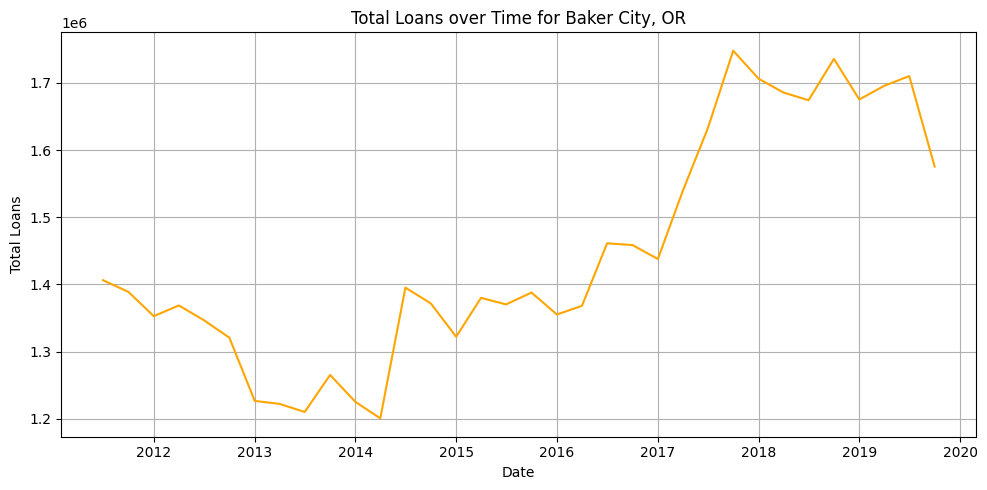

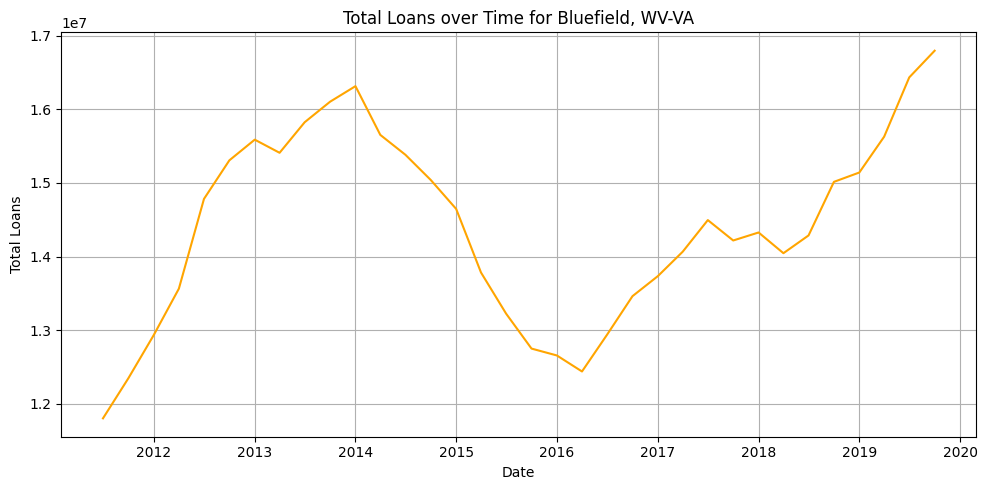

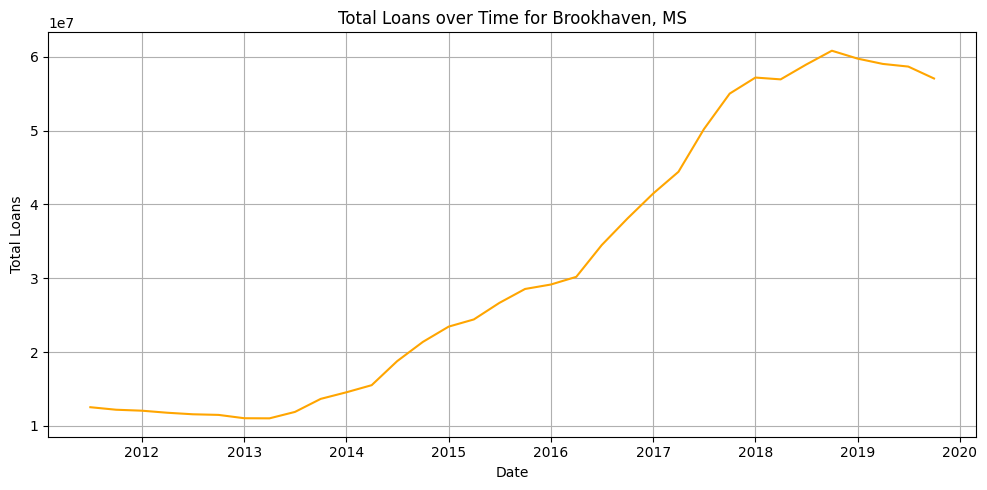

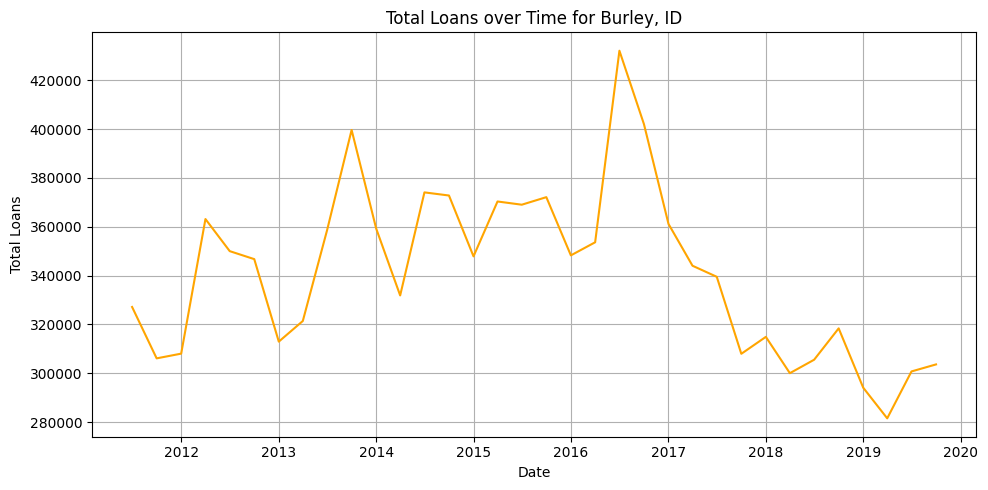

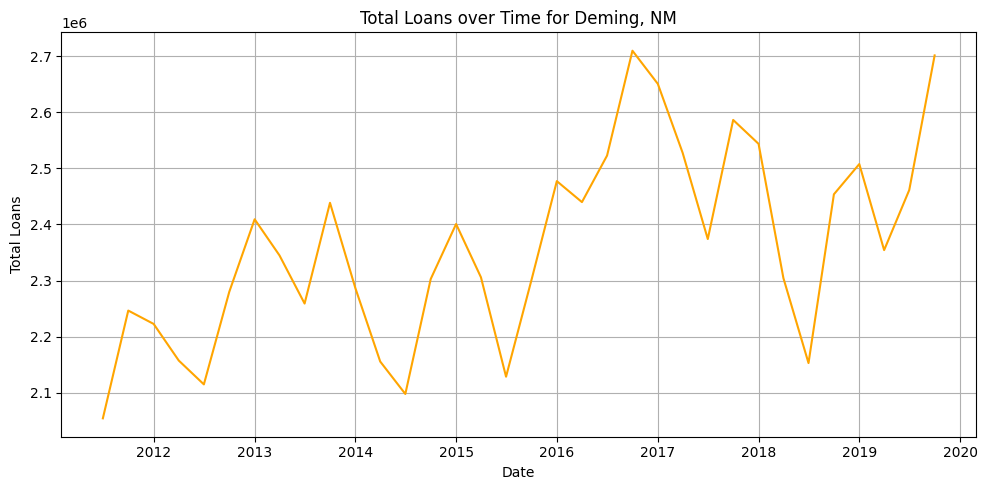

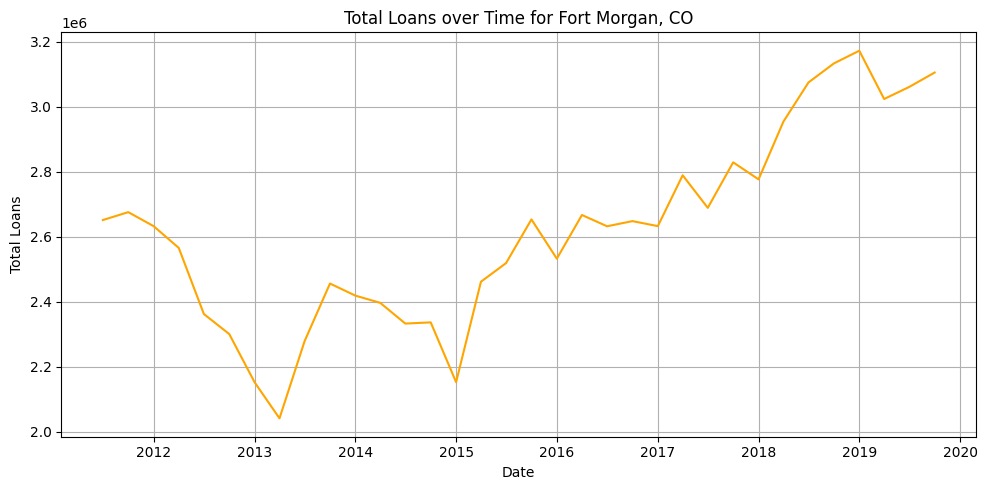

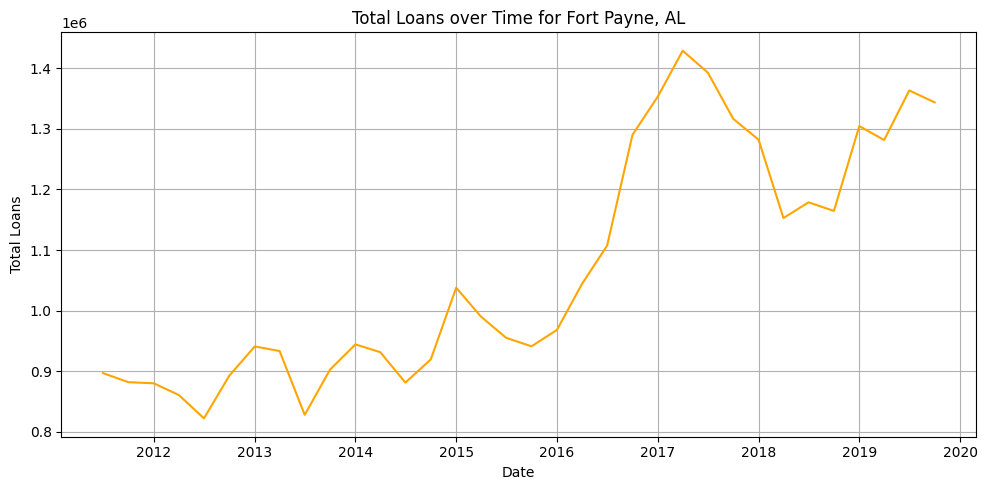

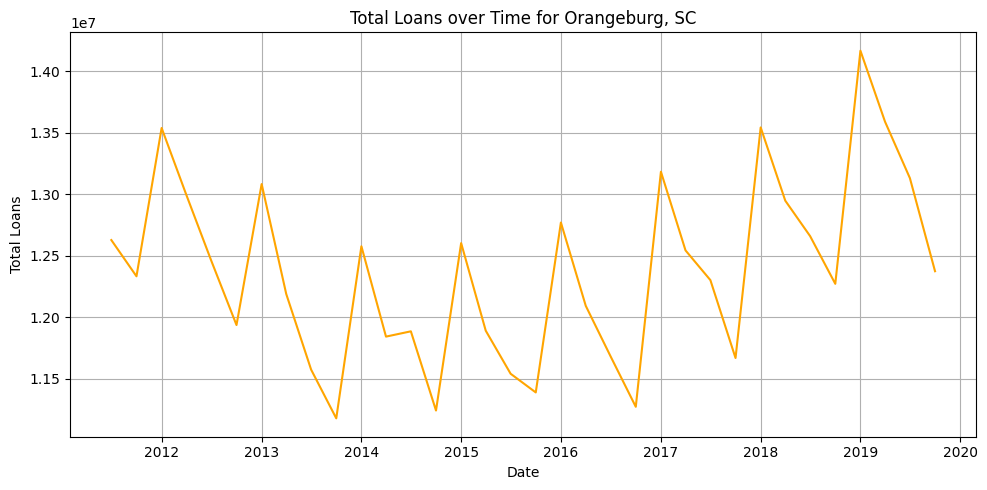

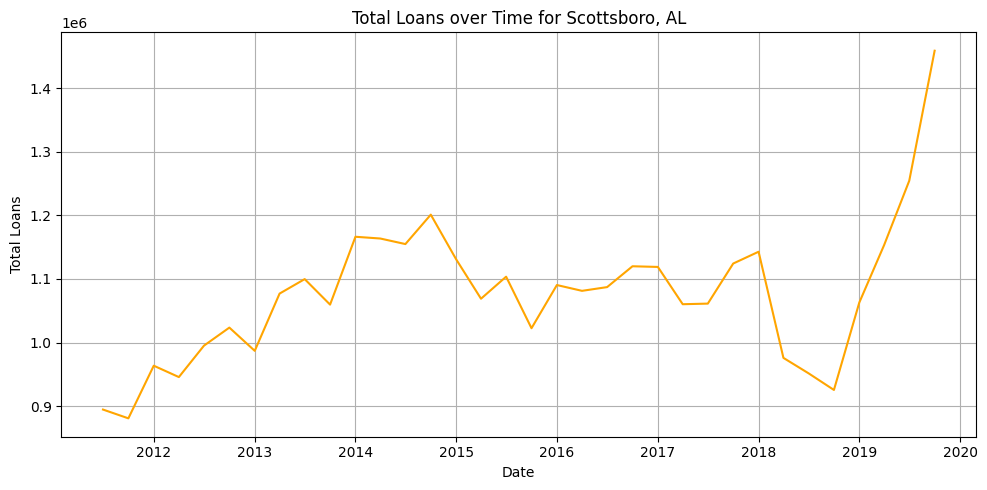

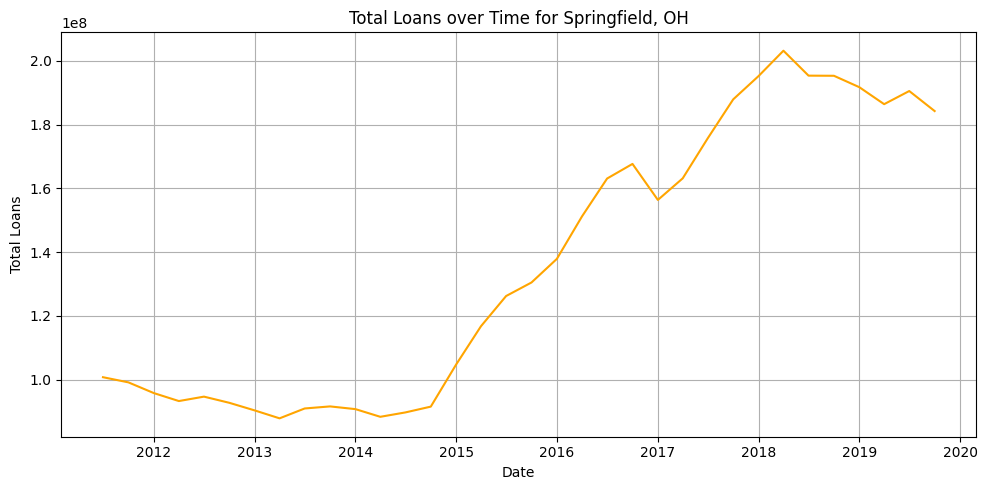

In [37]:
df = filtered_lending

# Get unique MSAs
msas = df['msa_name'].unique()

# Loop through each MSA and create plots
for msa in msas:
    msa_df = df[df['msa_name'] == msa]

    plt.figure(figsize=(10, 5))
    plt.plot(msa_df['date'], msa_df['total_loans'], label='Total Loans', color='orange')
    plt.title(f'Total Loans over Time for {msa}')
    plt.xlabel('Date')
    plt.ylabel('Total Loans')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

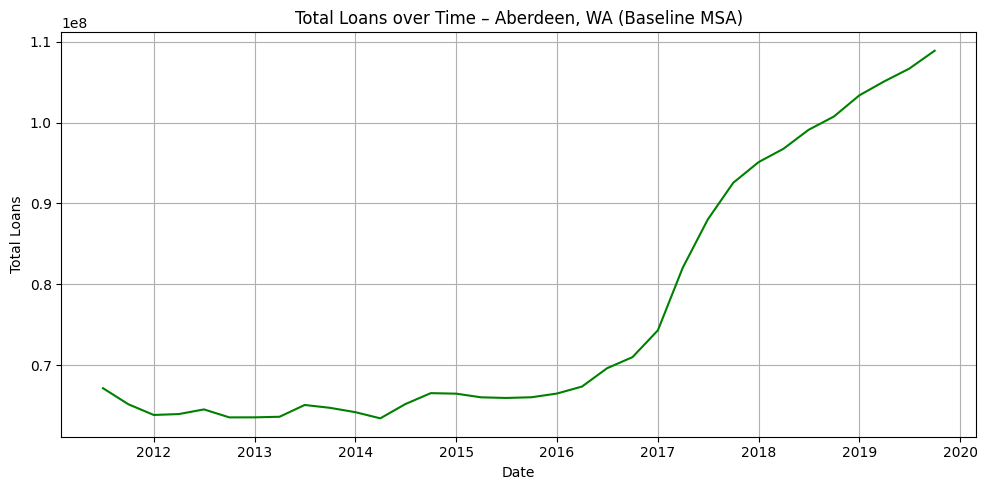

In [38]:
#aberdeen has a beta value of 1.08, close to standard
aberdeen_df = filtered_df[filtered_df['msa_name'] == 'Aberdeen, WA']

plt.figure(figsize=(10, 5))
plt.plot(aberdeen_df['date'], aberdeen_df['total_loans'], label='Total Loans (Aberdeen, WA)', color='green')
plt.title('Total Loans over Time – Aberdeen, WA (Baseline MSA)')
plt.xlabel('Date')
plt.ylabel('Total Loans')
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
df = filtered_df

df['date'] = pd.to_datetime(df['date'])  # Ensure date is datetime

# Group by MSA and calculate Coefficient of Variation (CV = std / mean)
cv_df = df.groupby('msa_name')['total_loans'].agg(['mean', 'std']).reset_index()
cv_df['cv'] = cv_df['std'] / cv_df['mean']

# Inspect the most volatile MSAs
cv_df_sorted = cv_df.sort_values('cv', ascending=False)
print(cv_df_sorted)  # Top 10 most volatile

# Filter out MSAs with high volatility (where CV>0.15)
stable_msas = cv_df[cv_df['cv'] <= 0.15]['msa_name']

# Create a filtered stable dataset
stable_df = df[df['msa_name'].isin(stable_msas)]

                         msa_name          mean           std        cv
76                 Brookhaven, MS  3.188485e+07  1.898567e+07  0.595445
57                  Blackfoot, ID  2.153882e+09  1.046880e+09  0.486044
594                    Wausau, WI  1.297249e+09  6.245257e+08  0.481423
427                      Peru, IN  1.012430e+07  4.872283e+06  0.481246
56                   Bismarck, ND  3.558448e+08  1.666747e+08  0.468392
..                            ...           ...           ...       ...
223                Greenville, OH  1.048344e+07  3.518684e+05  0.033564
371                  Montrose, CO  8.579544e+07  2.590066e+06  0.030189
210                 Goldsboro, NC  4.983442e+07  1.346914e+06  0.027028
418                   Palatka, FL  4.040727e+07  1.065129e+06  0.026360
239  Hickory-Lenoir-Morganton, NC  3.263880e+07  7.739005e+05  0.023711

[615 rows x 4 columns]


/tmp/ipython-input-39-2257000161.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])  # Ensure date is datetime


In [40]:
stable_msas

,msa_name
0,"Aberdeen, SD"
2,"Abilene, TX"
4,"Akron, OH"
5,"Alamogordo, NM"
10,"Albert Lea, MN"
...,...
604,"Wisconsin Rapids-Marshfield, WI"
605,"Wooster, OH"
610,"York-Hanover, PA"
613,"Yuma, AZ"


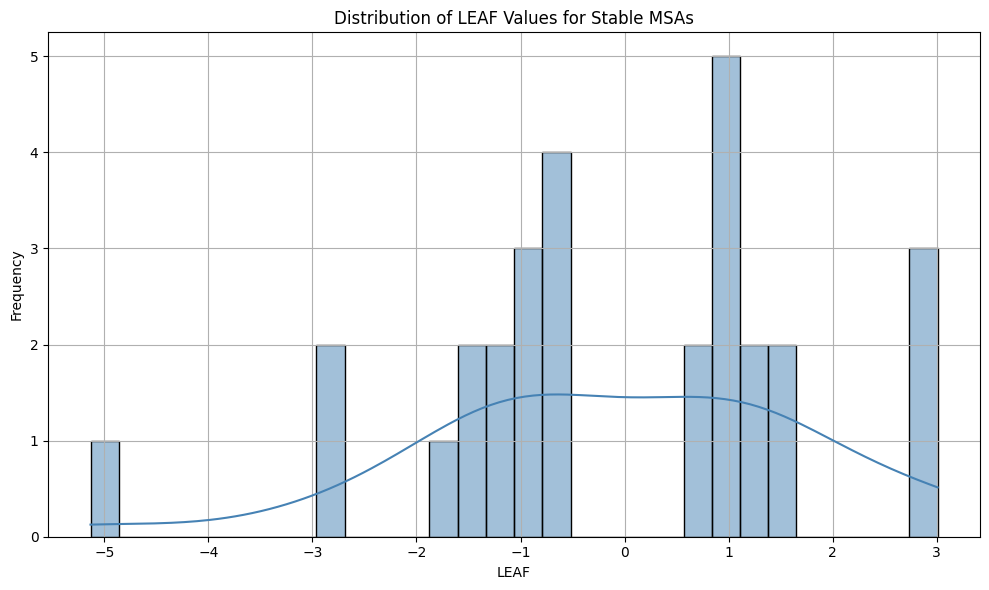

In [41]:
# Filter LEAF values for only the stable MSAs
stable_leaf_df = strong_leaf_df[strong_leaf_df['msa_name'].isin(stable_msas)]

# Plot distribution of LEAF values
plt.figure(figsize=(10, 6))
sns.histplot(stable_leaf_df['LEAF'], bins=30, kde=True, color='steelblue')
plt.title('Distribution of LEAF Values for Stable MSAs')
plt.xlabel('LEAF')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# increasing the bounds of volatility
df = filtered_df
cv_df = (
    df.groupby('msa_name')['total_loans']
    .agg(['mean', 'std'])
    .assign(cv=lambda x: x['std'] / x['mean'])
    .reset_index()
)

# Flag volatile MSAs
volatile_msas = cv_df[cv_df['cv'] > 0.3]['msa_name']
stable_msas = cv_df[cv_df['cv'] <= 0.3]['msa_name']

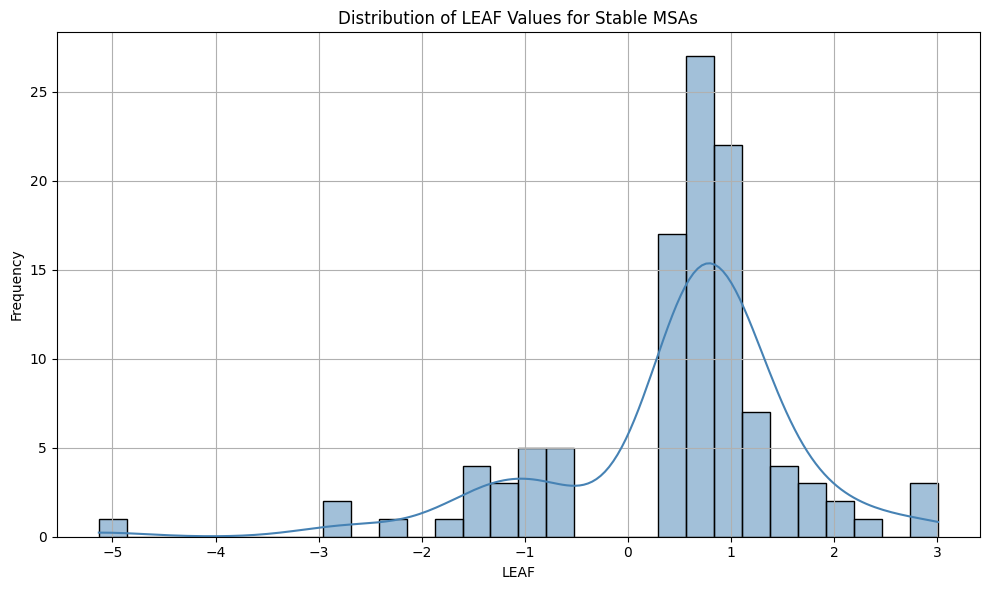

In [43]:
# Filter LEAF values for only the stable MSAs
stable_leaf_df = strong_leaf_df[strong_leaf_df['msa_name'].isin(stable_msas)]

# Plot distribution of LEAF values
plt.figure(figsize=(10, 6))
sns.histplot(stable_leaf_df['LEAF'], bins=30, kde=True, color='steelblue')
plt.title('Distribution of LEAF Values for Stable MSAs')
plt.xlabel('LEAF')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
# Load the data
msa_df = pd.read_excel("/MSA Mapping.xlsx", header=5)
cu_df = pd.read_excel("/Credit Union Profiles.xlsx", header=5)

msa_df.columns = msa_df.columns.str.lower()
cu_df.columns = cu_df.columns.str.lower()

# Create ZIP to MSA mapping
zip_to_msa = msa_df.set_index('zip_code')['metro_area.cbsa_title'].to_dict()

# Assign MSA to each CU
cu_df['msa_name'] = cu_df['zip'].map(zip_to_msa)

# Drop rows where MSA wasn't found (i.e., unmatched ZIPs)
cu_df = cu_df.dropna(subset=['msa_name'])

# Count CUs per MSA
cu_counts = cu_df.groupby('msa_name').size().reset_index(name='cu_count')

In [46]:
cu_counts

,msa_name,cu_count
0,"Aberdeen, SD",2
1,"Aberdeen, WA",4
2,"Abilene, TX",7
3,"Ada, OK",1
4,"Adrian, MI",2
...,...,...
620,"York-Hanover, PA",9
621,"Youngstown-Warren, OH",8
622,"Yuba City, CA",1
623,"Yuma, AZ",1


In [47]:
# Merge the CU counts into your stable_leaf_df
merged_df = stable_leaf_df.merge(cu_counts, on='msa_name', how='left')

# Define "extreme beta" cutoffs
# These can be adjusted depending on the tails you want to inspect (e.g. bottom/top 10%)
low_cutoff = merged_df['LEAF'].quantile(0.10)
high_cutoff = merged_df['LEAF'].quantile(0.90)

# Label MSAs as 'Low Beta', 'High Beta', or 'Mid Beta'
def label_beta(row):
    if row['LEAF'] <= low_cutoff:
        return 'Low Beta'
    elif row['LEAF'] >= high_cutoff:
        return 'High Beta'
    else:
        return 'Mid Beta'

merged_df['beta_category'] = merged_df.apply(label_beta, axis=1)

# analyze average CU counts by beta category
summary = merged_df.groupby('beta_category')['cu_count'].describe()
print(summary)

               count       mean        std  min  25%  50%  75%    max
beta_category                                                        
High Beta       11.0   2.818182   4.792039  1.0  1.0  1.0  1.5   17.0
Low Beta        11.0   2.727273   1.902152  1.0  1.0  2.0  3.5    6.0
Mid Beta        86.0  12.720930  23.595439  1.0  3.0  5.0  9.0  124.0


In [48]:
merged_df

,msa_name,LEAF,R_squared,assetSize,log_assetSize,cu_count,beta_category
0,"Aberdeen, WA",1.084347,0.135951,3802.0,3.580012,4,Mid Beta
1,"Abilene, TX",-0.772005,0.276198,601719.0,5.779394,7,Mid Beta
2,"Albany, OR",1.033140,0.246862,163152.0,5.212592,2,Mid Beta
3,"Anchorage, AK",0.740045,0.218930,12066329.0,7.081575,5,Mid Beta
4,"Andrews, TX",-1.540673,0.137967,6729.0,3.827951,1,Low Beta
...,...,...,...,...,...,...,...
103,"Tyler, TX",0.650742,0.138809,1596.0,3.203033,9,Mid Beta
104,"Visalia, CA",0.878100,0.107705,135245.0,5.131121,5,Mid Beta
105,"Warner Robins, GA",0.670155,0.130922,36545.0,4.562828,3,Mid Beta
106,"Washington-Arlington-Alexandria, DC-VA-MD-WV",0.463942,0.128351,431167.0,5.634646,95,Mid Beta


We observe that MSAs with extreme lending beta values — both highly procyclical and countercyclical — tend to have significantly fewer credit unions. In contrast, MSAs with mid-range beta values host a much larger number of CUs on average, suggesting that credit unions may be more active in economically stable and cyclically-aligned regions.

In [49]:
merged_df.to_csv("beta_with_CU_number.csv", index=False)

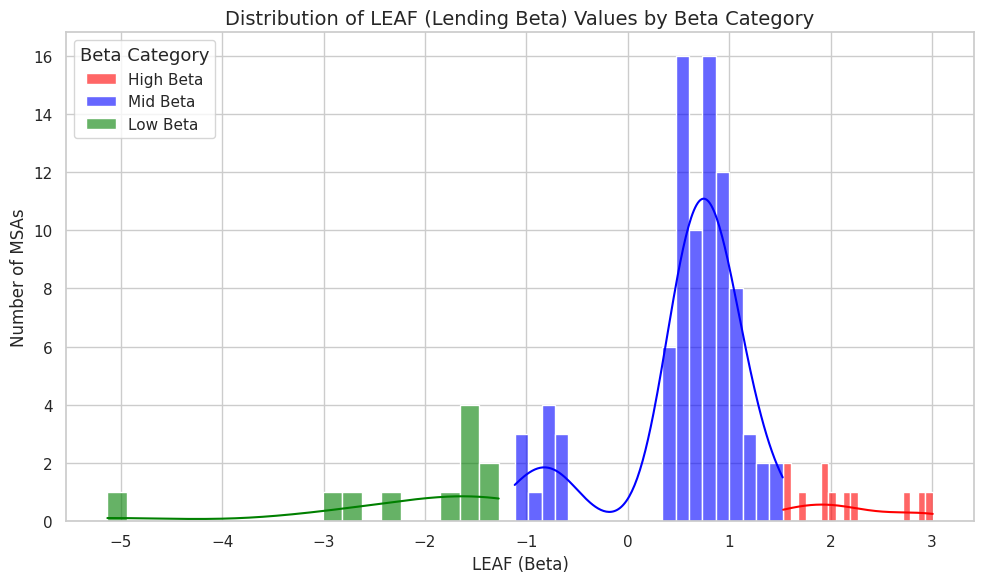

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = merged_df

# Set plot style
sns.set(style='whitegrid')

# Set up color mapping
color_map = {
    'High Beta': 'red',
    'Mid Beta': 'blue',
    'Low Beta': 'green'
}

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot each category separately
for category, color in color_map.items():
    subset = df[df['beta_category'] == category]
    sns.histplot(
        subset['LEAF'],
        kde=True,
        color=color,
        bins=20,
        label=category,
        alpha=0.6
    )

# Add titles and labels
plt.title('Distribution of LEAF (Lending Beta) Values by Beta Category', fontsize=14)
plt.xlabel('LEAF (Beta)', fontsize=12)
plt.ylabel('Number of MSAs', fontsize=12)

# Add legend/key
plt.legend(title='Beta Category', title_fontsize='13', fontsize='11', loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipython-input-59-2994322723.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='beta_category', y='cu_count', data=merged_df, palette={
/tmp/ipython-input-59-2994322723.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='beta_category', y='cu_count', data=merged_df, palette={


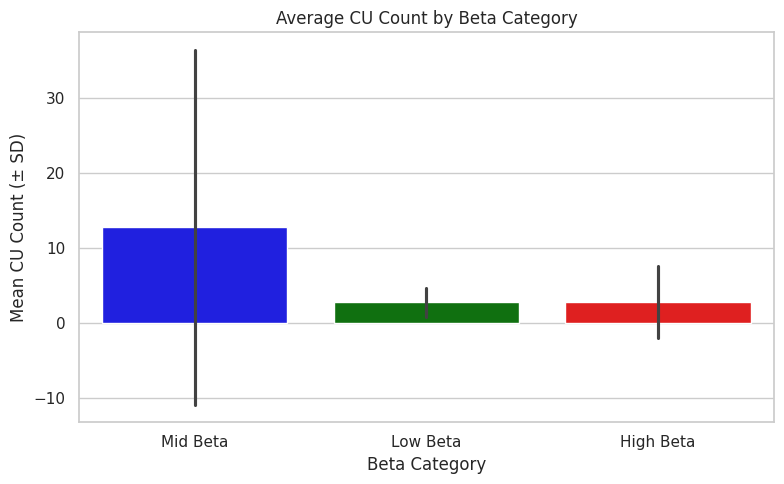

In [59]:
plt.figure(figsize=(8, 5))
sns.barplot(x='beta_category', y='cu_count', data=merged_df, palette={
    'Low Beta': 'green', 'Mid Beta': 'blue', 'High Beta': 'red'
}, estimator='mean', ci='sd')  # ci='sd' shows standard deviation error bars

plt.title('Average CU Count by Beta Category')
plt.xlabel('Beta Category')
plt.ylabel('Mean CU Count (± SD)')
plt.tight_layout()
plt.show()

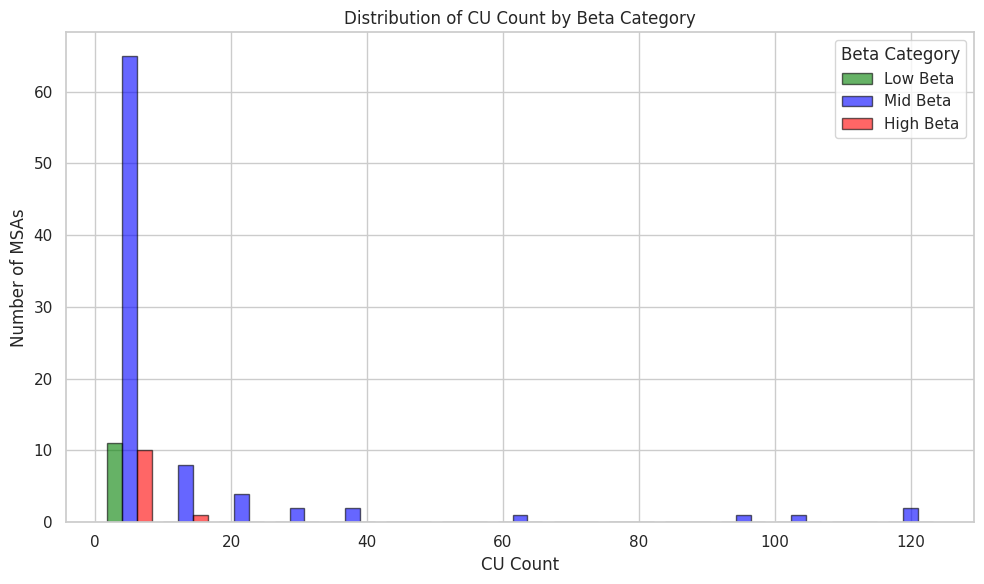

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = merged_df

# Separate by beta category
low = df[df['beta_category'] == 'Low Beta']['cu_count']
mid = df[df['beta_category'] == 'Mid Beta']['cu_count']
high = df[df['beta_category'] == 'High Beta']['cu_count']

plt.figure(figsize=(10, 6))

plt.hist([low, mid, high],
         bins=15,
         stacked=False,
         color=['green', 'blue', 'red'],
         label=['Low Beta', 'Mid Beta', 'High Beta'],
         alpha=0.6,
         edgecolor='black')

plt.title('Distribution of CU Count by Beta Category')
plt.xlabel('CU Count')
plt.ylabel('Number of MSAs')
plt.legend(title='Beta Category')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

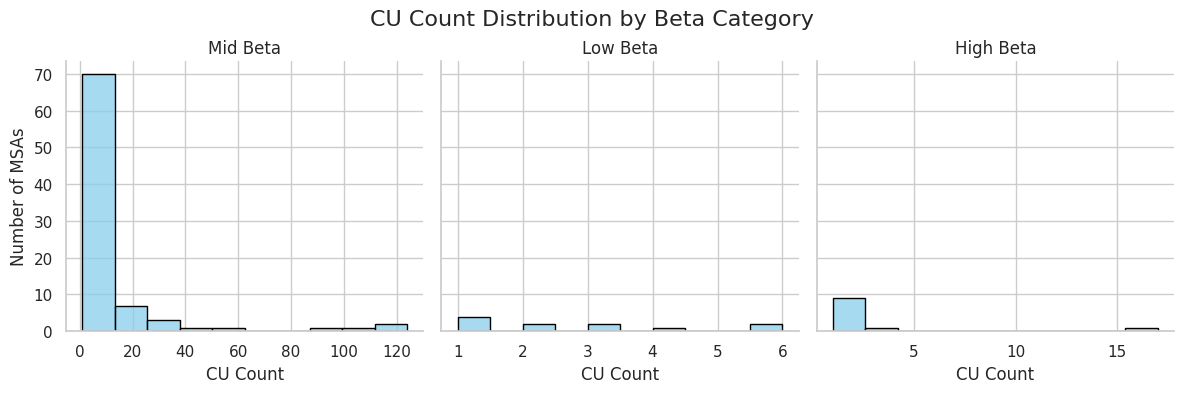

In [63]:
g = sns.FacetGrid(df, col="beta_category", col_wrap=3, height=4, sharex=False, sharey=True)
g.map(sns.histplot, "cu_count", bins=10, color="skyblue", edgecolor="black")

g.set_titles("{col_name}")
g.set_axis_labels("CU Count", "Number of MSAs")
g.fig.suptitle("CU Count Distribution by Beta Category", fontsize=16)
g.tight_layout()
g.fig.subplots_adjust(top=0.85)
plt.show()